In [13]:
import pandas as pd
import csv
import matplotlib
import matplotlib.pyplot as plt

In [14]:
perf_data = {}
perf_data_path = "../../simulator/traces/llama7b_bsz16/placements.csv"
with open(perf_data_path, "r", encoding="utf-8-sig") as f_data:
    reader_config = csv.DictReader(f_data)
    data_rows = list(reader_config)
for data_row in data_rows:
    exec_plan = str(data_row["exec_plan"])
    perf_data.setdefault(exec_plan,{})
    placement = str(data_row["placement"])
    perf_data[exec_plan].setdefault(placement,{})
    cpu_threads = int(data_row["cpu_threads"])
    perf_data[exec_plan][placement][cpu_threads]=float(data_row["iter_time"])

In [15]:
# resource limits
placements = ["8888","4444","4","1"]

exec_res_perf = {}
dafault_cpu_threads = 2

## Test the reconfigurability of Morphling.

In [16]:
import sys
import os
# Get the LLaMA model for evaluation.
# Build the performsance model for LLaMA-2-7B.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sched_dir = os.path.abspath(
    os.path.join(notebook_dir, "../../sched")
)
if sched_dir not in sys.path:
    sys.path.append(sched_dir)
from morphling_sched.performance_model import PerformanceModel
from llama7_config import llama7
llama_model = llama7()
llama_model.model_info()
perf_model = PerformanceModel("LLaMA-2-7B",6738423808 / 1024 / 1024,
                              llama_model.local_bsz,500,
                              llama_model.sequence_length*llama_model.hidden_size,
                              llama_model.num_hidden_layers,
                              llama_model.max_dp_atom_bsz,
                              llama_model.max_mp_atom_bsz,
                              llama_model.avail_placement,
                              llama_model.env_params,
                              llama_model.perf_params)

In [17]:
# Just transform the execution plan to the format of the csv.
def transform_exec_plan(origin_plan):
    if "zero-offload" in origin_plan:
        exec_plan = "zero-offload"
    elif "zero-dp" in origin_plan:
        exec_plan = "zero-dp"
    else:
        exec_plan = "dp"
    if "gc" in origin_plan:
        exec_plan += "+gc"
    elif "ga" in origin_plan:
        exec_plan += "+ga"
    return exec_plan

In [18]:
# The training performance of LLaMA-7B under Morphling.
# Morphling: always chooses the best execution plan under different resource limites.
execution_plan = "Morphling"
res_perf = []
for placement in placements:
    num_gpus = sum(int(i) for i in placement)
    # Provide the resource limits to the performance model.
    # Performance model will return the best execution plan and throughput prediction.
    perf_model.get_plan_with_fixed_res(num_gpus,dafault_cpu_threads,0,placement)
    if perf_model.res_matrix_3D[placement][0]>perf_model.res_matrix[num_gpus][dafault_cpu_threads][0][0]:
        exec_plan = ''.join(map(str,perf_model.res_matrix_3D[placement][1]))
        res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
        exec_plan = f'(PP={exec_plan[0]},TP={exec_plan[1]},DP={exec_plan[2]})'
    else:
        exec_plan = transform_exec_plan(perf_model.res_matrix[num_gpus][dafault_cpu_threads][0][1])
        res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
    print(f'Morphling chooses the execution plan: {exec_plan}, when the GPU placements are: {placement}, and the CPU threads are: {dafault_cpu_threads}. The corresponding performance is: {res_perf[-1]}.')
        
# 2x more cpus
res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads*2])
print(f'Morphling chooses the execution plan: {exec_plan}, when the GPU placements are: {placement}, and the CPU threads are: {dafault_cpu_threads*2}. The corresponding performance is: {res_perf[-1]}.')
exec_res_perf[execution_plan]=res_perf

Morphling chooses the execution plan: (PP=2,TP=4,DP=4), when the GPU placements are: 8888, and the CPU threads are: 2. The corresponding performance is: 1.165.
Morphling chooses the execution plan: (PP=4,TP=4,DP=1), when the GPU placements are: 4444, and the CPU threads are: 2. The corresponding performance is: 1.803.
Morphling chooses the execution plan: (PP=2,TP=2,DP=1), when the GPU placements are: 4, and the CPU threads are: 2. The corresponding performance is: 5.107.
Morphling chooses the execution plan: zero-offload+gc, when the GPU placements are: 1, and the CPU threads are: 2. The corresponding performance is: 66.0.
Morphling chooses the execution plan: zero-offload+gc, when the GPU placements are: 1, and the CPU threads are: 4. The corresponding performance is: 46.0.


## Get training performance of other execution plans.

In [19]:
# The training performance of LLaMA-7B under TP+DP.
# TP+DP: using TP inside nodes and DP across nodes.
execution_plan = "TP+DP"
res_perf = []
for placement in placements:
    num_nodes = len(placement)
    num_gpus_per_node = int(placement[0])
    num_gpus = sum(int(i) for i in placement)
    exec_plan = "1"+str(num_gpus_per_node)+str(num_gpus//num_gpus_per_node)
    res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
# 2x more cpus
res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads*2])
exec_res_perf[execution_plan]=res_perf

In [20]:
# The training performance of LLaMA-7B under TP+PP.
# TP+PP: using TP inside nodes and PP across nodes.
execution_plan = "TP+PP"
res_perf = []
for placement in placements:
    num_nodes = len(placement)
    num_gpus_per_node = int(placement[0])
    num_gpus = sum(int(i) for i in placement)
    exec_plan = str(num_gpus//num_gpus_per_node)+str(num_gpus_per_node)+"1"
    res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
# 2x more cpus
res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads*2])
exec_res_perf[execution_plan]=res_perf

In [21]:
# The training performance of LLaMA-7B under Megatron 3D.
# Megatron 3D: adopts a feasible TP+PP configuration such that 
# each partition fits in a GPU, then scales out using DP.
# For LLaMA-2-7B (global batch size=16), the most suitable TP+PP 
# configuration is TP=2 and PP=2.
execution_plan = "Megatron 3D"
res_perf = []
for placement in placements:
    num_gpus = sum(int(i) for i in placement)
    exec_plan = "2"+"2"+str(num_gpus//2//2)
    if exec_plan not in perf_data:
        res_perf.append(0)
    else:
        res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
# 2x more cpus
if exec_plan not in perf_data:
    res_perf.append(0)
else:
    res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads*2])
exec_res_perf[execution_plan]=res_perf

In [22]:
# The training performance of LLaMA-7B under ZeRO-Offload+GC.
execution_plan = "ZeRO-Offload+GC"
exec_plan=execution_plan.lower()
res_perf = []
for placement in placements:
    num_gpus = sum(int(i) for i in placement)
    res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads])
# 2x more cpus
res_perf.append(perf_data[exec_plan][placement][dafault_cpu_threads*2])
exec_res_perf[execution_plan]=res_perf

In [23]:
exec_res_perf

{'Morphling': [1.165, 1.803, 5.107, 66.0, 46.0],
 'TP+DP': [1.306, 2.372, 5.704, 0.0, 0.0],
 'TP+PP': [1.36, 1.803, 5.704, 0.0, 0.0],
 'Megatron 3D': [1.269, 2.084, 5.107, 0, 0],
 'ZeRO-Offload+GC': [0.0, 15.0, 30.0, 66.0, 46.0]}

## Plot the Figure 7.

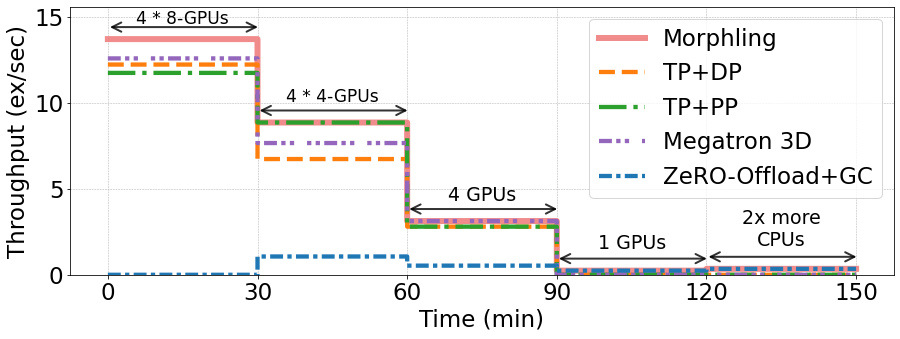

In [24]:
time_interval = 30
times = 5
diff = 0.001

x_axis = []
for i in range(times):
    x_axis+=[i*time_interval,(i+1)*time_interval-diff]


# Plt configuration.
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 23,'lines.linewidth': 4.3})
plt.figure(figsize=(13,5.2))

style=[ '--','-.',(0,(3, 1, 1, 1,1)), (0,(3, 1, 1, 1)), '.',]
colors=['#ff7f0e','#2ca02c', '#9467bd','#1f77b4',  '#8c564b',]

i=0
for exec_plan in exec_res_perf:
    if exec_plan == "Morphling":
        plt.plot(x_axis, [16/x if x!=0 else 0 for x in exec_res_perf[exec_plan] for _ in range(2)],label=exec_plan,c='lightcoral',lw=6,alpha=0.9)
    else:
        plt.plot(x_axis, [16/x if x!=0 else 0 for x in exec_res_perf[exec_plan] for _ in range(2)],linestyle=style[i],label=exec_plan,c=colors[i])
        i+=1

plt.legend(loc="upper right",ncol=1,handlelength=2)
plt.xticks([i*30 for i in range(0, times+1)])
plt.ylim([0,15.6])
plt.xlabel("Time (min)")
plt.ylabel("Throughput (ex/sec)")

morphling_perf = [16/x if x!=0 else 0 for x in exec_res_perf["Morphling"]]
for i in range(0,times):
    plt.annotate("", xy=(i*time_interval, morphling_perf[i]+0.7), xytext=((i+1)*time_interval+0.5, morphling_perf[i]+0.7),arrowprops=dict(arrowstyle="<->",linewidth=2,alpha=0.8))
plt.text(105,1.5,"1 GPUs",fontsize=19,horizontalalignment="center")
plt.text(75,4.3,"4 GPUs",fontsize=19,horizontalalignment="center")
plt.text(15,14.6,"4 * 8-GPUs",fontsize=17,horizontalalignment="center")
plt.text(45,10.1,"4 * 4-GPUs",fontsize=17,horizontalalignment="center")
plt.text(135,1.7,"2x more\nCPUs",fontsize=19,horizontalalignment="center")
plt.grid(linestyle = 'dashed', linewidth = 0.5)
plt.tight_layout()